In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("FFT.ipynb")

In [18]:
# version shenanigans
!pip install otter-grader --upgrade --quiet
!pip install -r requirements.txt --quiet
import otter
import scipy
grader = otter.Notebook("FFT.ipynb")
assert otter.__version__ >= "4.2.0", "Please restart your kernel."
assert scipy.__version__ >= "1.10.0", "Please restart your kernel."

# FFT and Polynomial Multiplication

Here, you will implement FFT, and then implement polynomial multiplication, using FFT as a black box.


__Note that the functions you write build upon one another. Therefore, it will be necessarily to correctly solve previous problems in the notebook to solve later problems.__


In [19]:
import math
import cmath
import numpy as np
from numpy.random import randint
from time import time
import matplotlib.pyplot as plt
import tqdm
import scipy

In [20]:
np.random.seed(114514)

In [21]:
def reversed_np_fft(*args, **kwargs):
    return np.roll(np.fft.fft(*args, **kwargs)[::-1], 1)

### Q1) Roots of Unity
$n$th root of unity are defined as complex numbers where $z^n=1$.  
Another definition would be $e^{\frac{2\pi ik}{n}}$ where $k={0, 1, \cdots, n-1}$.  
First, with any definition, write a function that, given $n$, outputs all $n$th root of unity.  
You can alternatively calculate it in form $a+bi$, but it is not required.

*Hint:* 
1) There are multiple ways to calculate roots of unity. You may find the constants `np.e` and `np.pi` useful or the function or the function `np.zeros()` and `np.roots()` useful depending on what method you choose*
2) Python supports arithmetic with complex numbers. You can enter complex literals in the form `a + bj` where `a` and `b` are integers. For example, you can have `2 + 3j`.

In [22]:
def roots_of_unities(n):
    """
        args: 
            n:int = n describes which root of unity to return
        return:
            a list of n complex numbers containing the n-th roots of unity [w_0, w_1, w_2, ..., w_{n-1}]
    """
    # BEGIN SOLUTION
    # solution based on finding the primitive root of unity then raising it to different powers
    sol = []
    primitive = np.e ** (2 * np.pi * 1j / n)
    for k in range(n):
        sol.append(primitive ** k)
    return sol
    """
    # Alternate solution based on finding the roots of the polynomial x^n - 1 = 0 
    poly = np.zeros(n + 1)
    poly[0] = 1
    poly[-1] = -1
    return np.roots(poly)
    """
    # END SOLUTION

To make sure your helper function is correct, we can draw the resulting values on the unit circle. Run the following cell and make sure the output is as you expect it to be:

_Points:_ 0.5

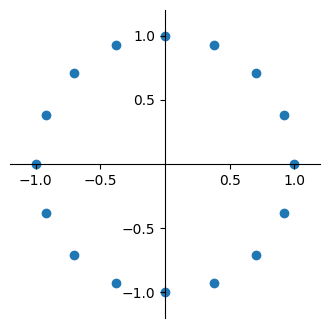

In [6]:
N = 16 # feel free to change this value and observe what happens
roots = roots_of_unities(N)

# Plot
f,ax = plt.subplots()
f.set_figwidth(4)
f.set_figheight(4)
plt.scatter([r.real for r in roots], [r.imag for r in roots]) 
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_xticks([-1, -0.5, 0.5, 1])
ax.set_yticks([-1, -0.5, 0.5, 1])
ax.xaxis.tick_bottom()

In [ ]:
grader.check("q1")

## Discrete Fourier Transform
In CS170, we define the process that transforms polynomials from coefficient representation to value representation (at next $2^n$th roots of unities) as "Discrete Fourier Transform".  
For example, for polynomial $P(x)=1+x+x^2+x^3$, its value representation would be $P(1)=4, P(i)=0, P(-1)=0, P(-i)=0$.  

### Q2) Naive DFT
Write an naive algorithm that calculated DFT.  
Hints: 
1) The input list is a list of coefficients but you might find `np.poly1d` useful. https://numpy.org/doc/stable/reference/generated/numpy.poly1d.html 
2) You might find the following function useful.

_Points:_ 1

In [8]:
# Utility function, returns next 2^n
hyperceil = lambda x: int(2 ** np.ceil(np.log2(x)))

In [9]:
def dft_naive(coeffs):
    """
    args:
        coeffs:List[] = list of numbers representing the coefficients of a polynomial where coeffs[i] 
                    is the coeffiecient of the term x^i
    return:
        List containing the results of evaluating the polynomial at the roots of unity 
        [P(w_0), P(w_1), P(w_2), ...]
    """
    # BEGIN SOLUTION
    n = hyperceil(len(coeffs))
    p = np.poly1d(coeffs[::-1])
    return [p(omega) for omega in roots_of_unities(n)]   
    # END SOLUTION

In [ ]:
grader.check("q2")

### Q3) FFT

FFT is an algorithm that calculates DFT in $\mathcal{O}(n \log n)$ time.

Now, you'll implement FFT by itself.  The way it is defined here, this takes in the coefficients of a polynomial as input, evaluates it on the $n$-th roots of unity, and returns the list of these values.  For instance, calling 

$$
FFT([1, 2, 3, 0], \; [1, i, -1, -i])
$$

should evaluate the polynomial $1 + 2x + 3x^2$ on the points $1, i, -1, -i$, returning

$$
[6, \; -2 + 2i, \; 2, \; -2 - 2i]
$$

Recall that to do this efficiently for a polynomial 

$$
P(x) = a_0 + a_1x + a_2x^2 + \cdots + a_{n - 1} x^{n - 1}
$$

we define two other polynomials $E$ and $O$, containing the coefficients of the even and odd degree terms respectively,

$$
E(x) := a_0 + a_2x + \cdots + a_{n - 2}x^{n/2 - 1}, \qquad O(x) := a_1 + a_3x + \cdots = a_{n - 1}x^{n/2 - 1}
$$

which satisfy the relation

$$
P(x) = E(x^2) + xO(x^2)
$$

We recursively run FFT on $E$ and $O$, evaluating them on the $n/2$-th roots of unity, then use these values to evaluate $P$ on the $n$-th roots of unity, via the above relation.

Implement this procedure below, where $\text{"coeffs"}$ are the coefficients of the polynomial we want to evaluate (with the coefficient of $x^i$ at index $i$), and where  

$$
\text{roots} = [1, \omega, \omega^2, \ldots, \omega^{n - 1}]
$$

for some primitive $n$-th root of unity $\omega$ where $n$ is a power of $2$.  (Note:  Arithmetic operations on complex numbers in python work just like they do for floats or ints.  Also, you can use $\text{A[::k]}$ to take every $k$-th element of an array A)

In [11]:
def fft(coeffs, roots):
    """
    args:
        coeffs:List[] = list of numbers representing the coefficients of a polynomial where coeffs[i] 
                    is the coeffiecient of the term x^i
        roots:List[] = list containing the roots of unity [w_0, w_1, w_2, ..., w_{n-1}]
    return:
        List containing the results of evaluating the polynomial at the roots of unity 
        [P(w_0), P(w_1), P(w_2), ...]
    """
    n = len(coeffs)
    assert n == hyperceil(n)
    # BEGIN SOLUTION
    if n == 1:
        return coeffs[:]
    e_coeff = coeffs[0::2]
    o_coeff = coeffs[1::2]
    e = fft(e_coeff, roots[::2])
    o = fft(o_coeff, roots[::2])
    
    res = np.zeros(n, dtype = np.complex_)
    for i in range(n//2):
        res[i] = e[i] + roots[i] * o[i]
        res[i + n//2] = e[i] + roots[i + n//2] * o[i]
    return res
    # END SOLUTION

### Testing

Here's a sanity check to test your implementation.  Calling $FFT([1, 2, 3, 0], [1, 1j, -1, -1j])$ should output $[6, \; -2 + 2j, \; 2, \; -2 - 2j]$ (Python uses $j$ for the imaginary unit instead of $i$.)

In [12]:
expected = [6, -2+2j, 2, -2-2j]
actual = fft([1, 2, 3, 0], [1, 1j, -1, -1j])
print("expected: {}".format(expected))
print("actual:   {}".format(actual))

expected: [6, (-2+2j), 2, (-2-2j)]
actual:   [ 6.+0.j -2.+2.j  2.+0.j -2.-2.j]


If you correctly implemented the FFT algorithm, and aren't naively evaluating on each point, the result should rely on the input values being roots of unity. Therefore, the call $FFT([1, 2, 3, 0], [1, 2, 3, 4])$ should NOT return the values of $1 + 2x + 3x^2$ on the inputs $[1, 2, 3, 4]$ (which would be $[6, 17, 34, 57]$):

_Points:_ 3

In [13]:
not_expected = [6, 17, 34, 57]
actual = fft([1, 2, 3, 0], [1, 2, 3, 4])
print("NOT expected: {}".format(not_expected))
print("actual:       {}".format(actual))

NOT expected: [6, 17, 34, 57]
actual:       [ 6.+0.j 14.+0.j 10.+0.j 18.+0.j]


In [ ]:
grader.check("q3")

### Q4) Inverse FFT
Now that you know your FFT is correct, implement IFFT.  
IFFT can be implemented in less than 3 lines, you can check the bottom of DPV page 75 to see how it is finished.


*Hint:*
Python supports computing the inverse of a complex number by raising it to the power of $-1$. In other words, suppose `x` is a complex number, the inverse is `x**(-1)`.

_Points:_ 1.5

In [15]:
def ifft(vals, roots):
    """
    args:
        val:List[] = List containing the results of evaluating the polynomial at the roots of unity 
                    [P(w_0), P(w_1), P(w_2), ...]
        
        roots:List[] = list containing the roots of unity [w_0, w_1, w_2, ..., w_{n-1}]
        
    return:
        List containing the results of evaluating the polynomial at the roots of unity 
        [P(w_0), P(w_1), P(w_2), ...]
    """
    n = len(vals)
    assert n == hyperceil(n)
    # BEGIN SOLUTION
    iroots = np.array(roots) ** -1
    return np.array(fft(vals, iroots) / n)
    # END SOLUTION

In [ ]:
grader.check("q4")

## Polynomial Multiplication

### The following part is optional and ungraded, but you may find it helpful for understanding how FFT is used to perform polynomial multiplication.

Now you'll implement polynomial multiplication, using your FFT function as a black box.  Recall that to do this, we first run FFT on the coefficients of each polynomial to evaluate them on the $n$-th roots of unity for a sufficiently large power of 2,  which we call $n$.  We then multiply these values together pointwise, and finally run the inverse FFT on these values to convert back to coefficient form, obtaining the coefficient of the product.  To perform inverse FFT, we can simply run FFT, but with the roots of unity inverted, and divide by $n$ at the end.

Note that FFT and IFFT only accepts polynomials of degree $2^n-1$, so you would need to pad coefficients to the next `hyperceil(n)`. 

You may find defining the `pad` function to be helpful but are not required to do so.

_Points:_ 0

In [27]:
def pad(coeffs, to):
    """
    args:
        coeffs:List[] = list of numbers representing the coefficients of a polynomial where coeffs[i] 
                    is the coeffiecient of the term x^i
        to:int = the final length coeffs should be after padding
    
    return:
        List of coefficients zero padded to length 'to'
    """
    # BEGIN SOLUTION
    return np.pad(coeffs, (0, to - len(coeffs)), "constant", constant_values=0)
    # END SOLUTION

def poly_multiply(coeffs1, coeffs2):
    """
    args:
        coeffs1:List[] = list of numbers representing the coefficients of a polynomial where coeffs[i] 
                    is the coeffiecient of the term x^i
        coeffs2:List[] = list of numbers representing the coefficients of a polynomial where coeffs[i] 
                    is the coeffiecient of the term x^i
    
    return:
        List of coefficients corresponding to the product polynomial of the two inputs.
    """
    # BEGIN SOLUTION
    n = hyperceil(len(coeffs1) + len(coeffs2) - 1)
    v1 = fft(pad(coeffs1, n), roots_of_unities(n))
    v2 = fft(pad(coeffs2, n), roots_of_unities(n))
    v = v1 * v2 # only works with numpy arrays
    return ifft(v, roots_of_unities(n))
    # END SOLUTION

### Testing

In [18]:
def round_complex_to_int(lst):
    return [round(x.real) for x in lst]

def zero_pop(lst):
    return np.trim_zeros(lst, "b")

Here are a couple sanity checks for your solution.

In [19]:
expected = [4, 13, 22, 15]
actual = round_complex_to_int(poly_multiply([1, 2, 3], [4, 5]))
print("expected: {}".format(expected))
print("actual:   {}".format(actual))

expected: [4, 13, 22, 15]
actual:   [4, 13, 22, 15]


In [20]:
expected = [4, 13, 28, 27, 18, 0, 0, 0]
actual = round_complex_to_int(poly_multiply([1, 2, 3], [4, 5, 6]))
print("expected: {}".format(expected))
print("actual:   {}".format(actual))

expected: [4, 13, 28, 27, 18, 0, 0, 0]
actual:   [4, 13, 28, 27, 18, 0, 0, 0]


One quirk of FFT is that we use complex numbers to multiply integer polynomials, so this leads to floating point errors.  You can see this with the following call, which will probably not return exact integer values (unless you did something in your implementation to handle this):

In [21]:
result = poly_multiply([1, 2, 3], [4, 5, 6])
result

array([4.00000000e+00+1.04360964e-14j, 1.30000000e+01+2.44249065e-15j,
       2.80000000e+01-4.44089210e-16j, 2.70000000e+01-5.10702591e-15j,
       1.80000000e+01-4.21884749e-15j, 0.00000000e+00-2.88657986e-15j,
       3.55271368e-15-3.10862447e-15j, 1.77635684e-15-7.77156117e-15j])

Therefore, if we're only interested in integers, like many of the homework problems, we have to round the result:

In [22]:
result = round_complex_to_int(result)
result

[4, 13, 28, 27, 18, 0, 0, 0]

However, there might still be trailing zeros we have to remove:

In [23]:
zero_pop(result)

[4, 13, 28, 27, 18]

This (hopefully) gives us exactly what we would have gotten by multiplying the polynomials normally, $[4, 13, 28, 27, 18]$.

### Runtime Comparison

Here, we compare the runtime of polynomial multiplication with FFT to the naive algorithm.

In [24]:
def poly_multiply_naive(coeffs1, coeffs2):
    n1, n2 = len(coeffs1), len(coeffs2)
    n = n1 + n2 - 1
    prod_coeffs = [0] * n
    for deg in range(n):
        for i in range(max(0, deg + 1 - n2), min(n1, deg + 1)):
            prod_coeffs[deg] += coeffs1[i] * coeffs2[deg - i]
    return prod_coeffs

In [25]:
poly_multiply_naive([3,4,5], [7,2,7,4])

[21, 34, 64, 50, 51, 20]

Running the following cell, you should see FFT perform similarly to or worse than the naive algorithm on small inputs, but perform significantly better once inputs are sufficiently large, which should be apparent by how long you have to wait for the naive algorithm to finish on the largest input (you might need to run the next cell twice to see the plot for some reason):


size: 1
FFT time:   0.000163
naive time: 0.000012
speed up: 0.074671

size: 10
FFT time:   0.001016
naive time: 0.000029
speed up: 0.028390

size: 100
FFT time:   0.008373
naive time: 0.001124
speed up: 0.134262

size: 1000
FFT time:   0.072853
naive time: 0.120234
speed up: 1.650363

size: 10000
FFT time:   1.344252
naive time: 12.042071
speed up: 8.958194


Text(0.5, 1.0, 'FFT Polynomial Multiplication Speedup')

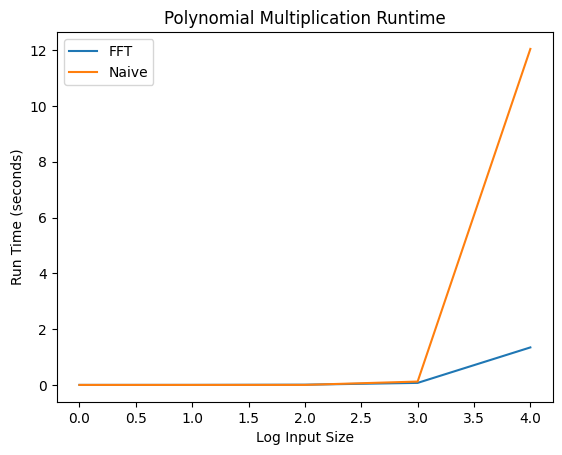

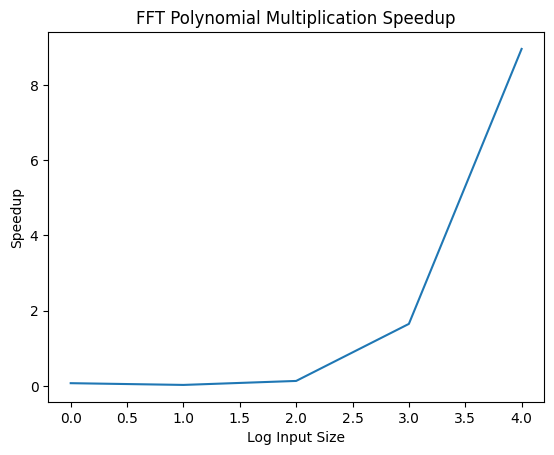

In [26]:
def rand_ints(lo, hi, length):
    ints = list(randint(lo, hi, length))
    ints = [int(x) for x in ints]
    return ints

def record(array, value, name):
    array.append(value)
    print("%s%f" % (name, value))

fft_times = []
naive_times = []
speed_ups = []

for i in range(5):
    n = 10 ** i
    print("\nsize: %d" % n)
    poly1 = rand_ints(1, 100, n)
    poly2 = rand_ints(1, 100, n)
    time1 = time()
    fft_res = poly_multiply(poly1, poly2)
    fft_res = zero_pop(round_complex_to_int(fft_res))
    time2 = time()
    fft_time = time2 - time1
    record(fft_times, fft_time, "FFT time:   ")
    naive_res = poly_multiply_naive(poly1, poly2)
    time3 = time()
    naive_time = time3 - time2
    record(naive_times, naive_time, "naive time: ")
    assert fft_res == naive_res
    speed_up = naive_time / fft_time
    record(speed_ups, speed_up, "speed up: ")

plt.plot(fft_times, label="FFT")
plt.plot(naive_times, label="Naive")
plt.xlabel("Log Input Size")
plt.ylabel("Run Time (seconds)")
plt.legend(loc="upper left")
plt.title("Polynomial Multiplication Runtime")

plt.figure()
plt.plot(speed_ups)
plt.xlabel("Log Input Size")
plt.ylabel("Speedup")
plt.title("FFT Polynomial Multiplication Speedup")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [ ]:
grader.export(pdf=False, force_save=True, run_tests=True)